In [1]:
# import modules
import pandas as pd
import pickle
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.inspection import permutation_importance

In [2]:
# load data
df = pickle.load(open('data/abc_regression_modeling.p', 'rb')) # rb is reading
df.head()

,customer_id,distance_from_store,gender,credit_score,customer_loyalty_score,total_sales,total_items,transaction_count,product_area_count,avg_basket_value
0,74,3.38,F,0.59,0.263,2563.71,297,44,5,58.266136
1,524,4.76,F,0.52,0.298,2996.02,357,49,5,61.143265
2,607,4.45,F,0.49,0.337,2853.82,350,49,5,58.241224
3,343,0.91,M,0.54,0.873,2388.31,272,54,5,44.227963
4,322,3.02,F,0.63,0.350,2401.64,278,50,5,48.032800


In [3]:
# shuffle data
df = shuffle(df)

In [4]:
# drop unecessary columns
df.drop('customer_id', axis = 1, inplace = True)

In [5]:
# deal with missing value
print(df.isna().sum())
df.dropna(how = 'any', inplace = True) # we don't need to use imputer in this case since we have a very small amount of na records

distance_from_store       2
gender                    3
credit_score              2
customer_loyalty_score    0
total_sales               0
total_items               0
transaction_count         0
product_area_count        0
avg_basket_value          0
dtype: int64


In [6]:
# split input and output variables
X = df.drop(['customer_loyalty_score'], axis = 1) # input vairables
y = df['customer_loyalty_score'] # output variable

In [7]:
# split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [8]:
# deal with categorical variables
categorical_vars = ['gender']

# enstantiate one hot encoder object and apply to training and test data
one_hot_encoder = OneHotEncoder(sparse = False, drop = 'first') # returns array, drops one of the binary categorical columns to reduce multicollinearity

X_train_encoded = one_hot_encoder.fit_transform(X_train[categorical_vars])
X_test_encoded = one_hot_encoder.transform(X_test[categorical_vars])

# create object to get feature names
encoder_feature_names = one_hot_encoder.get_feature_names_out(categorical_vars)

# create data frame with encoder variables and feature names, and concat to original data frame and reset index
X_train_encoded = pd.DataFrame(X_train_encoded, columns = encoder_feature_names)
X_train = pd.concat([X_train.reset_index (drop = True), X_train_encoded.reset_index (drop = True)], axis = 1) # axis 1 concats columns and not rows
X_train.drop(categorical_vars, axis = 1, inplace = True) # axis 1 drops columns and not rows

X_test_encoded = pd.DataFrame(X_test_encoded, columns = encoder_feature_names)
X_test = pd.concat([X_test.reset_index (drop = True), X_test_encoded.reset_index (drop = True)], axis = 1) # axis 1 concats columns and not rows
X_test.drop(categorical_vars, axis = 1, inplace = True) # axis 1 drops columns and not rows

In [9]:
# train model
regressor = RandomForestRegressor()
regressor.fit(X_train, y_train)

RandomForestRegressor()

In [10]:
# predict on the test set
y_pred = regressor.predict(X_test)
y_pred

array([0.81763, 0.27382, 0.26585, 0.21429, 0.03821, 0.27401, 0.21991,
       0.94184, 0.54884, 0.40369, 0.0948 , 0.6129 , 0.35684, 0.23602,
       0.88358, 0.63257, 0.78316, 0.49721, 0.30785, 0.01886, 0.35866,
       0.87176, 0.34011, 0.56431, 0.23137, 0.8647 , 0.11654, 0.7869 ,
       0.76829, 0.66811, 0.14957, 0.08042, 0.03904, 0.6888 , 0.21417,
       0.26029, 0.79969, 0.10789, 0.14046, 0.94841, 0.26334, 0.31225,
       0.95412, 0.32952, 0.25045, 0.14262, 0.88689, 0.81397, 0.71095,
       0.57966, 0.39553, 0.68333, 0.33644, 0.86962, 0.39205, 0.3907 ,
       0.65003, 0.92667, 0.47666, 0.09642, 0.06242, 0.07569, 0.27361,
       0.59853, 0.41079, 0.7466 , 0.67473, 0.34519, 0.58503, 0.04372,
       0.75747, 0.26693, 0.87871, 0.12819, 0.43012, 0.89652, 0.44787,
       0.72893, 0.61531])

In [11]:
# calculate R-Squared
r_squared = r2_score(y_test, y_pred)
print(f'R-Squared = {r_squared}')

R-Squared = 0.9353164688884795


In [12]:
# cross validation
cv = KFold(n_splits = 4, shuffle = True)
cv_scores = cross_val_score(regressor, X_train, y_train, cv = cv, scoring = 'r2')
cv_scores.mean()

0.9254309749803122

In [13]:
# calculate adjusted r-squared
num_data_points, num_input_vars = X_test.shape # output of .shape is the number of rows and columns
adjusted_r_squared = 1 - (1 - r_squared) * (num_data_points - 1) / (num_data_points - num_input_vars - 1)
print(f'Adjusted R-Squared = {adjusted_r_squared}')

Adjusted R-Squared = 0.9279240653328772


In [14]:
# feature importance summary
feature_importance = pd.DataFrame(regressor.feature_importances_)
feature_names = pd.DataFrame(X.columns)

feature_importance_summary = pd.concat([feature_names, feature_importance], axis = 1)
feature_importance_summary.columns = ['input_variable', 'feature_importance']
feature_importance_summary.sort_values(by = 'feature_importance', inplace = True)

feature_importance_summary

,input_variable,feature_importance
1,gender,0.010057
6,product_area_count,0.011338
7,avg_basket_value,0.028491
4,total_items,0.047668
5,transaction_count,0.048593
3,total_sales,0.102720
2,credit_score,0.120209
0,distance_from_store,0.630924


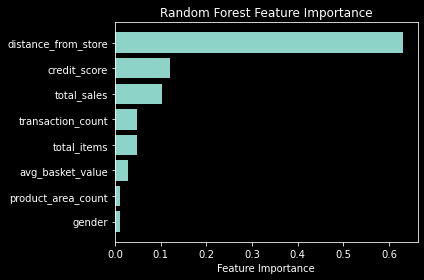

In [15]:
# feature importance bar plot
plt.barh(
    feature_importance_summary['input_variable'],
    feature_importance_summary['feature_importance']
)

plt.title("Random Forest Feature Importance")
plt.xlabel('Feature Importance')
plt.tight_layout()

plt.show()

In [16]:
# permutation importance (decrease in model performance when particular features are randomly shuffled)
# this is another form of feature importance
permutation_result = permutation_importance(regressor, X_test, y_test, n_repeats = 10) # n_repeats number of times random shuffling is applied
permutation_result

{'importances_mean': array([ 1.36930674e+00, -1.95374817e-04,  6.04019386e-02,  1.05391909e-01,
         9.11015098e-03,  4.68647167e-02,  2.50521790e-03,  4.13819745e-02]),
 'importances_std': array([0.1315735 , 0.00129265, 0.01399824, 0.02959888, 0.00588935,
        0.00871861, 0.00135064, 0.00979448]),
 'importances': array([[ 1.36057755e+00,  1.26598351e+00,  1.60228074e+00,
          1.49016539e+00,  1.35367528e+00,  1.37090967e+00,
          1.30674121e+00,  1.54545168e+00,  1.19425955e+00,
          1.20302282e+00],
        [ 1.71047422e-03,  6.85118601e-04,  2.02374596e-03,
         -6.19331635e-04,  1.26317138e-04, -9.64321511e-04,
         -1.33273923e-03, -1.42110555e-03, -4.69364223e-05,
         -2.11496974e-03],
        [ 3.63601091e-02,  7.93682844e-02,  4.49496224e-02,
          5.99855121e-02,  6.04190776e-02,  6.67494842e-02,
          6.68118920e-02,  4.23200842e-02,  6.96594522e-02,
          7.73958677e-02],
        [ 5.63174386e-02,  1.21411742e-01,  8.75050783e-0

In [17]:
# permutation importance summary
permutation_importance = pd.DataFrame(permutation_result['importances_mean']) # average importance result for each input variable
feature_names = pd.DataFrame(X.columns)

permutation_importance_summary = pd.concat([feature_names, permutation_importance], axis = 1)
permutation_importance_summary.columns = ['input_variable', 'permutation_importance']
permutation_importance_summary.sort_values(by = 'permutation_importance', inplace = True)

permutation_importance_summary

,input_variable,permutation_importance
1,gender,-0.000195
6,product_area_count,0.002505
4,total_items,0.009110
7,avg_basket_value,0.041382
5,transaction_count,0.046865
2,credit_score,0.060402
3,total_sales,0.105392
0,distance_from_store,1.369307


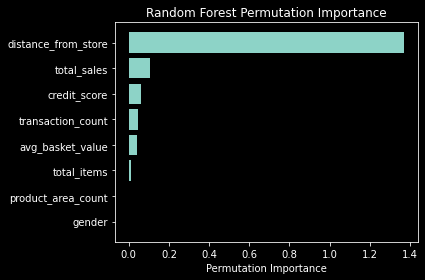

In [18]:
# permutation importance bar plot
plt.barh(
    permutation_importance_summary['input_variable'],
    permutation_importance_summary['permutation_importance']
)

plt.title("Random Forest Permutation Importance")
plt.xlabel('Permutation Importance')
plt.tight_layout()

plt.show()

In [19]:
# checking predictions under the hood
prediction_test = [X_test.iloc[0]] # creates data frame with test record
prediction_test_score = y_pred[0]

print(f'Record at Index 0 has a predicted loyalty score of {prediction_test_score}\n')
print('Data for Index 0:')
prediction_test

Record at Index 0 has a predicted loyalty score of 0.8176299999999996

Data for Index 0:


[distance_from_store      0.500000
 credit_score             0.590000
 total_sales            938.020000
 total_items            239.000000
 transaction_count       53.000000
 product_area_count       4.000000
 avg_basket_value        17.698491
 gender_M                 0.000000
 Name: 0, dtype: float64]

In [20]:
# loop through each decision tree that was made in our model and pass in our test record
# average the predictions and confirm it is the same as our prediction above

predictions = []
tree_count = 0

for tree in regressor.estimators_:
    # create prediction for each tree and return value for that prediction [0]
    prediction = tree.predict(prediction_test)[0]
    # append that prediction to the prediction list
    predictions.append(prediction)
    # increment value of tree_count
    tree_count += 1

predictions_mean = sum(predictions) / tree_count

# print predictions
print(predictions)
print('\n')

# print mean loyalty score prediction
print(f'''
Record at Index 0 has a predicted loyalty score of {prediction_test_score} when initially ran thought the model.
Record at Index 0 has an average predicted loyalty score of {predictions_mean} when ran indivudally through all decision trees.
'''
)

[0.786, 0.874, 0.797, 0.878, 0.8080000000000002, 0.786, 0.832, 0.903, 0.77, 0.797, 0.797, 0.896, 0.808, 0.808, 0.786, 0.797, 0.832, 0.896, 0.77, 0.808, 0.874, 0.759, 0.791, 0.808, 0.874, 0.77, 0.832, 0.874, 0.791, 0.786, 0.832, 0.874, 0.832, 0.797, 0.874, 0.739, 0.863, 0.77, 0.832, 0.808, 0.786, 0.797, 0.896, 0.791, 0.791, 0.832, 0.77, 0.797, 0.874, 0.896, 0.832, 0.874, 0.797, 0.808, 0.808, 0.832, 0.791, 0.808, 0.791, 0.808, 0.874, 0.775, 0.791, 0.874, 0.878, 0.832, 0.65, 0.77, 0.786, 0.78, 0.808, 0.898, 0.808, 0.889, 0.797, 0.874, 0.759, 0.874, 0.874, 0.713, 0.791, 0.832, 0.8080000000000002, 0.832, 0.878, 0.863, 0.791, 0.874, 0.832, 0.756, 0.791, 0.7799999999999999, 0.808, 0.8080000000000002, 0.791, 0.878, 0.786, 0.832, 0.77, 0.77]



Record at Index 0 has a predicted loyalty score of 0.8176299999999996 when initially ran thought the model.
Record at Index 0 has an average predicted loyalty score of 0.8176299999999996 when ran indivudally through all decision trees.



In [21]:
# save objects to predict loyalty scores for customers that the agency could not match
pickle.dump(regressor, open('data/random_forest_regression_model.p', 'wb'))
pickle.dump(one_hot_encoder, open('data/random_forest_regression_model_ohe.p', 'wb'))